# <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

**Постановка задачи**<a class="anchor" id="course_project_task"></a>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения
2. Укажите свой ник на kaggle

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.

**Примерное описание этапов выполнения курсового проекта**<a class="anchor" id="course_project_steps"></a>

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

# Обзор данных<a class="anchor" id="course_project_review"></a>

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [147]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import tqdm

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (roc_auc_score, roc_curve, auc, confusion_matrix, f1_score, \
                             accuracy_score, classification_report, plot_confusion_matrix, \
                             plot_precision_recall_curve, precision_recall_curve, recall_score,
                             plot_roc_curve)

**Пути к директориям и файлам**

In [2]:
TRAIN_DATASET_PATH = './data/course_project_train.csv'
TEST_DATASET_PATH = './data/course_project_test.csv'

**Загрузка данных**

In [72]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

# Обзор датасета

In [39]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [40]:
df_train.shape

(7500, 17)

In [78]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Annual Income                   5943 non-null   float64
 1   Tax Liens                       7500 non-null   float64
 2   Number of Open Accounts         7500 non-null   float64
 3   Years of Credit History         7500 non-null   float64
 4   Maximum Open Credit             7500 non-null   float64
 5   Number of Credit Problems       7500 non-null   float64
 6   Months since last delinquent    3420 non-null   float64
 7   Bankruptcies                    7486 non-null   float64
 8   Current Loan Amount             7500 non-null   float64
 9   Current Credit Balance          7500 non-null   float64
 10  Monthly Debt                    7500 non-null   float64
 11  Credit Score                    5943 non-null   float64
 12  Credit Default                  75

In [42]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [43]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [44]:
df_test.shape

(2500, 16)

Количество уникальных значений

In [45]:
df_train.nunique()

Home Ownership                     4
Annual Income                   5478
Years in current job              11
Tax Liens                          8
Number of Open Accounts           39
Years of Credit History          408
Maximum Open Credit             6963
Number of Credit Problems          8
Months since last delinquent      89
Bankruptcies                       5
Purpose                           15
Term                               2
Current Loan Amount             5386
Current Credit Balance          6592
Monthly Debt                    6716
Credit Score                     268
Credit Default                     2
dtype: int64

In [46]:
df_test.nunique()

Home Ownership                     4
Annual Income                   1929
Years in current job              11
Tax Liens                          8
Number of Open Accounts           35
Years of Credit History          345
Maximum Open Credit             2435
Number of Credit Problems          8
Months since last delinquent      83
Bankruptcies                       6
Purpose                           14
Term                               2
Current Loan Amount             2026
Current Credit Balance          2385
Monthly Debt                    2416
Credit Score                     211
dtype: int64

## Обзор категориальных переменных

In [47]:
df_train['Home Ownership'].unique()

array(['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage'], dtype=object)

In [48]:
df_train['Years in current job'].unique()

array([nan, '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

In [49]:
df_train['Term'].unique()

array(['Short Term', 'Long Term'], dtype=object)

In [50]:
df_train['Purpose'].unique()

array(['debt consolidation', 'other', 'home improvements', 'take a trip',
       'buy a car', 'small business', 'business loan', 'wedding',
       'educational expenses', 'buy house', 'medical bills', 'moving',
       'major purchase', 'vacation', 'renewable energy'], dtype=object)

---

# Baseline

Decision Tree Classifier

Обновляем датасет

In [429]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

Заполняем пропуски медианой

In [391]:
df_train.median(axis=0)

Annual Income                   1168386.0
Tax Liens                             0.0
Number of Open Accounts              10.0
Years of Credit History              17.0
Maximum Open Credit              478159.0
Number of Credit Problems             0.0
Months since last delinquent         32.0
Bankruptcies                          0.0
Current Loan Amount              309573.0
Current Credit Balance           209323.0
Monthly Debt                      16076.5
Credit Score                        731.0
Credit Default                        0.0
dtype: float64

In [423]:
df_train.mode()[0:]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Home Mortgage,969475.0,10+ years,0.0,9.0,15.0,0.0,0.0,14.0,0.0,debt consolidation,Short Term,99999999.0,0.0,0.0,740.0,0.0
1,NaN,1043651.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,1058376.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1161660.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1338113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [433]:
df_train = df_train.fillna(df_train.mode()[0:])
#df_train = df_train.fillna(df_train.median(axis=0), axis=0)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10+ years,0.0,11.0,26.3,685960.0,1.0,14.0,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


Переводим категориальные признаки в количественные

In [425]:
df_train = pd.get_dummies(df_train)
df_test = pd.get_dummies(df_test)
df_train.nunique()

Annual Income                     5478
Tax Liens                            8
Number of Open Accounts             39
Years of Credit History            408
Maximum Open Credit               6963
Number of Credit Problems            8
Months since last delinquent        89
Bankruptcies                         5
Current Loan Amount               5386
Current Credit Balance            6592
Monthly Debt                      6716
Credit Score                       268
Credit Default                       2
Home Ownership_Have Mortgage         2
Home Ownership_Home Mortgage         2
Home Ownership_Own Home              2
Home Ownership_Rent                  2
Years in current job_1 year          2
Years in current job_10+ years       2
Years in current job_2 years         2
Years in current job_3 years         2
Years in current job_4 years         2
Years in current job_5 years         2
Years in current job_6 years         2
Years in current job_7 years         2
Years in current job_8 ye

Формируем выборки

In [426]:
X = df_train.drop(columns='Credit Default')
y = df_train['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)
X_train.shape, X_test.shape

((6000, 44), (1500, 44))

In [427]:
X = df_train.drop(columns='Credit Default')
y = df_train['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)
X_train.shape, X_test.shape

((6000, 44), (1500, 44))

Подбираем гиперпараметры

In [428]:
%%time
tree = DecisionTreeClassifier(random_state=1)

param_grid=[{
             'max_depth': range(1, 15), 
             'min_samples_leaf': range(1, 10), 
            }]

grid_search = GridSearchCV(tree, param_grid, cv=5)
grid_search.fit(X_train, y_train)
tree = grid_search.best_estimator_

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [407]:
grid_search.best_params_

{'max_depth': 5, 'min_samples_leaf': 5}

Предсказываем значения трейновой и тестовой выборки

In [384]:
pred_train = tree.predict(X_train)
pred_test = tree.predict(X_test)

Подсчитываем метрики <a class="anchor" id="count_metrics"></a>

In [385]:
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)
print(f'Accuracy на трейне {accuracy_train}')
print(f'Accuracy на тесте {accuracy_test}')

Accuracy на трейне 0.7786666666666666
Accuracy на тесте 0.7673333333333333


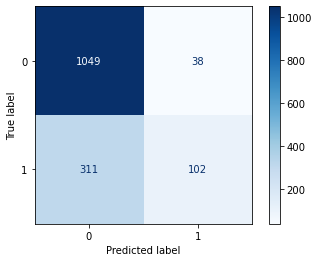

In [386]:
plot_confusion_matrix(tree, X_test, y_test, cmap=plt.cm.Blues);

Основные метрики из Classification report

In [387]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1087
           1       0.73      0.25      0.37       413

    accuracy                           0.77      1500
   macro avg       0.75      0.61      0.61      1500
weighted avg       0.76      0.77      0.72      1500



In [388]:
print(f'F1-score = {round(f1_score(y_test, pred_test), 3)}')

F1-score = 0.369


Замена NaN на медиану F1 = 0.369


---

## Baseline с отбором признаков

Обновляем датасет

In [352]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

Выделение целевой переменной и групп признаков

In [353]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

NUMERICAL_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
                           'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                           'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

Корреляция с базовыми признаками

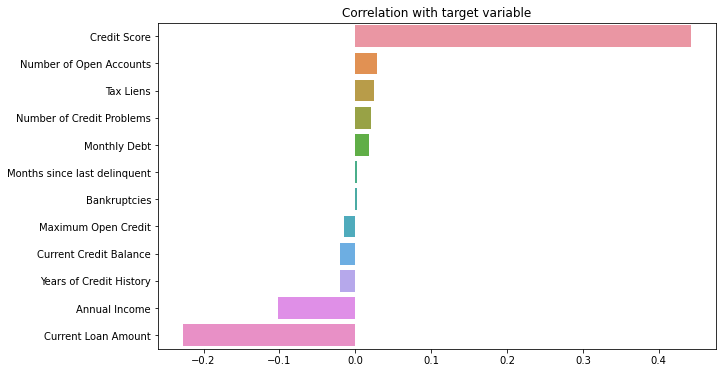

In [354]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 6))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

**Выбираем наиболее значимые признаки** [:кол-во признаков]

In [355]:
features = corr_with_target.sort_values(ascending=False, key=lambda x: abs(x))[:12]
features

Credit Score                    0.442050
Current Loan Amount            -0.226522
Annual Income                  -0.101375
Number of Open Accounts         0.028884
Tax Liens                       0.024368
Years of Credit History        -0.020567
Number of Credit Problems       0.020088
Current Credit Balance         -0.019522
Monthly Debt                    0.018480
Maximum Open Credit            -0.014275
Months since last delinquent    0.002598
Bankruptcies                    0.001648
Name: Credit Default, dtype: float64

Список выбранных признаков

In [356]:
features_names = features.index
features_names

Index(['Credit Score', 'Current Loan Amount', 'Annual Income',
       'Number of Open Accounts', 'Tax Liens', 'Years of Credit History',
       'Number of Credit Problems', 'Current Credit Balance', 'Monthly Debt',
       'Maximum Open Credit', 'Months since last delinquent', 'Bankruptcies'],
      dtype='object')

Оставляем в датасете только выбранные признаки

In [357]:
df_train = df_train[features_names]
df_train.head()

,Credit Score,Current Loan Amount,Annual Income,Number of Open Accounts,Tax Liens,Years of Credit History,Number of Credit Problems,Current Credit Balance,Monthly Debt,Maximum Open Credit,Months since last delinquent,Bankruptcies
0,749.0,99999999.0,482087.0,11.0,0.0,26.3,1.0,47386.0,7914.0,685960.0,NaN,1.0
1,737.0,264968.0,1025487.0,15.0,0.0,15.3,0.0,394972.0,18373.0,1181730.0,NaN,0.0
2,742.0,99999999.0,751412.0,11.0,0.0,35.0,0.0,308389.0,13651.0,1182434.0,NaN,0.0
3,694.0,121396.0,805068.0,8.0,0.0,22.5,1.0,95855.0,11338.0,147400.0,NaN,1.0
4,719.0,125840.0,776264.0,13.0,0.0,13.6,1.0,93309.0,7180.0,385836.0,NaN,0.0


In [358]:
df_test = df_test[features_names]
df_test.head()

,Credit Score,Current Loan Amount,Annual Income,Number of Open Accounts,Tax Liens,Years of Credit History,Number of Credit Problems,Current Credit Balance,Monthly Debt,Maximum Open Credit,Months since last delinquent,Bankruptcies
0,NaN,162470.0,NaN,9.0,0.0,12.5,0.0,105906.0,6813.0,220968.0,70.0,0.0
1,699.0,78298.0,231838.0,6.0,0.0,32.7,0.0,46037.0,2318.0,55946.0,8.0,0.0
2,7260.0,200178.0,1152540.0,10.0,0.0,13.7,0.0,146490.0,18729.0,204600.0,NaN,0.0
3,739.0,217382.0,1220313.0,16.0,0.0,17.0,0.0,213199.0,27559.0,456302.0,70.0,0.0
4,706.0,777634.0,2340952.0,11.0,0.0,23.6,0.0,425391.0,42605.0,1207272.0,NaN,0.0


Заполняем пропуски медианой

In [359]:
df_train = df_train.fillna(df_train.median(axis=0), axis=0)
df_test = df_test.fillna(df_test.median(axis=0), axis=0)

Категориальных признаков нет, поэтому нечего переводить в количественные

Формируем выборки

In [360]:
X = df_train
y = pd.read_csv(TRAIN_DATASET_PATH)['Credit Default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)
X_train.shape, X_test.shape

((6000, 12), (1500, 12))

Подбираем гиперпараметры

In [361]:
%%time
tree = DecisionTreeClassifier(random_state=1)

param_grid=[{
             'max_depth': range(1, 15), 
             'min_samples_leaf': range(1, 10), 
            }]

grid_search = GridSearchCV(tree, param_grid, cv=5)
grid_search.fit(X_train, y_train)
tree = grid_search.best_estimator_

Wall time: 13.3 s


In [362]:
grid_search.best_params_

{'max_depth': 1, 'min_samples_leaf': 1}

Предсказываем значения трейновой и тестовой выборки

In [363]:
pred_train = tree.predict(X_train)
pred_test = tree.predict(X_test)

Подсчитываем метрики <a class="anchor" id="count_metrics"></a>

In [364]:
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred_test)
print(f'Accuracy на трейне {accuracy_train}')
print(f'Accuracy на тесте {accuracy_test}')

Accuracy на трейне 0.772
Accuracy на тесте 0.77


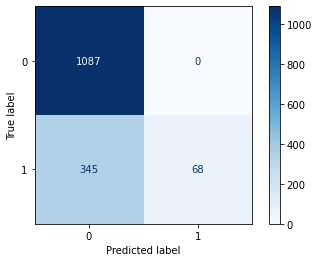

In [365]:
plot_confusion_matrix(tree, X_test, y_test, cmap=plt.cm.Blues);

Основные метрики из Classification report

In [366]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1087
           1       1.00      0.16      0.28       413

    accuracy                           0.77      1500
   macro avg       0.88      0.58      0.57      1500
weighted avg       0.83      0.77      0.70      1500



In [367]:
print(f'F1-score = {round(f1_score(y_test, pred_test), 3)}')

F1-score = 0.283


Результаты исключение признаков - F1 score низкое и не меняется

|No features | F1 score|
|-|-|
|5 | 0.283|
|6|0.283|
|7|0.283|
|8|0.283|
|9|0.283|
|10|0.283|
|11|0.283|
|12|0.283|

# Обработка выбросов

# Обработка пропусков

https://medium.com/@kyawsawhtoon/a-guide-to-knn-imputation-95e2dc496e

Идеи заполнения:
- knn https://medium.com/@kyawsawhtoon/a-guide-to-knn-imputation-95e2dc496e
- медианной по группе. Например заполнить Annual Income по Years of Credit History

In [63]:
df_train.isna().sum()

Annual Income                     1557
Tax Liens                            0
Number of Open Accounts              0
Years of Credit History              0
Maximum Open Credit                  0
Number of Credit Problems            0
Months since last delinquent      4080
Bankruptcies                        14
Current Loan Amount                  0
Current Credit Balance               0
Monthly Debt                         0
Credit Score                      1557
Credit Default                       0
Home Ownership_Have Mortgage         0
Home Ownership_Home Mortgage         0
Home Ownership_Own Home              0
Home Ownership_Rent                  0
Years in current job_1 year          0
Years in current job_10+ years       0
Years in current job_2 years         0
Years in current job_3 years         0
Years in current job_4 years         0
Years in current job_5 years         0
Years in current job_6 years         0
Years in current job_7 years         0
Years in current job_8 ye

Количество пропущенных значений по признакам:
```
Annual Income                   1557
Years in current job             371
Months since last delinquent    4081
Bankruptcies                      14
Credit Score                    1557
```

# Анализ данных

# Отбор признаков

# Балансировка классов

# Подбор моделей, получение бейзлана

# Выбор наилучшей модели, настройка гиперпараметров

# Проверка качества, борьба с переобучением

# Интерпретация результатов